# Analiza opinii z Twittera na temat gry Cyberpunk2077
Tematem pracy jest analiza opinii o polskiej grze Cyberpunk2077 wśród użytkowników Twittera. Gra CD Projekt Red wzbudziła duże emocje, głównie z powodu gigantycznych oczekiwań przed premierą oraz wielu głośnych opóźnień w produkcji. Poszukujemy tweetów po hasztagu **#cyberpunk2077**.

## Podział pracy

# 1. Wstęp
Opinie na ten temat dzielimy na 7 okresów:
- 10 czerwca 2018 - pierwszy zwiastun rozgrywki na E3 2018
- 27 sierpnia 2018 - pierwsza prezentacja rozgrywki dla publiczności
- 16 stycznia 2020 - pierwsze przesunięcie premiery na 17 września 2020
- 18 czerwca 2020 - drugie przesunięcie premiery na 19 listopada 2020
- 29 września 2020 - trzecie przesunięcie premiery na 10 grudnia 2020
- 10 grudnia 2020 - premiera gry na PlayStation 4, Windows i Xbox One, (tu sprawdzamy emocje 2 dni przed i po premierze)

Dodatkowo pod lupę w analizie bierzemy okres codziennie od 1 listopada 2020 do 28 lutego 2021.

## Pobieranie tweetów
Tweety pobieramy za pomocą biblioteki Snscrape. Niestety przez ciągłe zmiany w zarządzie Twittera nie można było pobrać bardziej szczegółowych informacji, takich jak lokalizacja. Ostatecznie mamy 8 plików csv, z łączną ilością **160 tyś. tweetów.**


In [26]:
import csv
import snscrape.modules.twitter as sntwitter

max_len = 30_000


def save_to_csv(name, tweets):
    fieldnames = ['ID', 'Content', 'User', 'Date', 'Lang', 'Place', 'Hashtags']
    with open(name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames)
        writer.writeheader()
        for tweet in tweets:
            writer.writerow({'ID': tweet.id,
                             'Content': str(tweet.rawContent).replace('\n', ''),
                             'User': tweet.user.username,
                             'Date': tweet.date,
                             'Lang': tweet.lang,
                             'Place': tweet.place,
                             'Hashtags': tweet.hashtags})

    print(f"Pobrane tweety zostały zapisane do pliku: {name}")


def q1():
    query = '(#cyberpunk2077) until:2018-06-12 since:2018-06-10'
    tweets = []
    i = 0

    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        tweets.append(tweet)
        i += 1
        print(i, tweet.date, query)

        if len(tweets) >= max_len:
            break

    csv_file = 'data_MIXED/cyberpunk_first_trailer.csv'
    save_to_csv(csv_file, tweets)

Każdy z okresów jest zapisywany do osobnego pliku csv. Zapisujemy w nim informacje o ID, CONTENT, USER, DATE, LANG, PLACE, HASHTAGS. Maksymalnie w pliku może być 30 000 wierszy. Tweety są pobierane dla każdego okresu danych, zmieniana jest tylko wartość zapytania *'query'*.

# 2. Preprocessing

## Tłumaczenie
Tweety są napisane w różnych językach, więc należy je przetłumaczyć na język angielski.
Kod do tłumaczenia z użyciem biblioteki *'googletrans'*.

In [27]:
from googletrans import Translator


def translate_to_english(text, lang):
    if lang == 'en':
        return text
    elif lang == 'und' or lang == 'qme' or lang == 'qht':
        return text
    elif lang == 'zh':
        translator = Translator(service_urls=['translate.googleapis.com'])
        translation = translator.translate(text, dest='en', src='zh-tw')
        return translation.text
    elif lang == 'in':
        translator = Translator(service_urls=['translate.googleapis.com'])
        translation = translator.translate(text, dest='en', src='es')
        return translation.text
    else:
        translator = Translator(service_urls=['translate.googleapis.com'])
        translation = translator.translate(text, dest='en', src=lang)
        return translation.text
    

def q1():
    translate_to_english.call_counter = 0
    df = pd.read_csv('data_MIXED/cyberpunk_first_move.csv')
    df['Content'] = df.apply(lambda row: translate_to_english(row['Content'], row['Lang']), axis=1)

    df.to_csv('ENG_first_move.csv', index=False)

Operacja tłumaczenia jest wykonywana dla każdego pliku, na kształt funkcji *q1()*. Po wykonaniu kodu, mamy 7 plików csv z przedrostkiem ENG_ na początku, np.*ENG_first_trailer.csv*

## Preprocessing dla Bag of Words
Preprocessing będzie zawierał tokenizację, stopwords i lematyzację. Dodatkowo, na początku usuwamy linki i wybrane frazy, które nie dotyczą naszego tematu.

In [28]:
import nltk
import re
import csv
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocessing(nazwa,phrases_to_remove,words_to_remove): # funkcja zajmująca się preprocessingiem
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    tweets = []
    with open(nazwa, 'r',encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            tweet = row['Content']
            tweet = re.sub(r'http\S+|https\S+', '', tweet) # usuwanie linków z tweetów
            for phrase in phrases_to_remove:
                tweet = tweet.replace(phrase, '') # usunięcie powtarzajacych się fraz
            tokens = word_tokenize(tweet) # tokenizacja
            tokens = [token.lower() for token in tokens if token.isalpha()]  # Usunięcie znaków niebędących literami
            tokens = [token for token in tokens if token not in stop_words]  # Usunięcie stopwords
            tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lematyzacja
            tokens = [token for token in tokens if token not in words_to_remove]# Usunięcie pojedynczych słów

            processed_tweet = ' '.join(tokens)
            tweets.append(processed_tweet)
    return tweets

phrases_to_remove = ['cyberpunk', 'youtube', 'video', 'game', 'liked youtube','youtube cyberpunk','cyberpunk official','official trailer','official trailer cyberpunk','liked youtube','cyberpunk official','liked youtube cyberpunk',"halo infinite","dying","light","devil","cry", "devil may cry", "dying light","shadow die","fallout","metro exodus","tomb raider","kingdom heart","forza horizon","microsoft","division","xbox","forza horizon"]
words_to_remove = ['may', 'cry','cyberpunk','youtube','shadow','devil','die','dying','trailer','gear','war']

tweets_first_trailer = preprocessing('data_ENGLISH/ENG_first_trailer.csv',phrases_to_remove,words_to_remove)
tweets_first_gameplay = preprocessing('data_ENGLISH/ENG_first_gameplay.csv',phrases_to_remove,words_to_remove)
tweets_first_move = preprocessing('data_ENGLISH/ENG_first_move.csv',phrases_to_remove,words_to_remove)
tweets_second_move = preprocessing('data_ENGLISH/ENG_second_move.csv',phrases_to_remove,words_to_remove)
tweets_third_move = preprocessing('data_ENGLISH/ENG_third_move.csv',phrases_to_remove,words_to_remove)
tweets_before_release = preprocessing('data_ENGLISH/ENG_before_release.csv',phrases_to_remove,words_to_remove)
tweets_after_release = preprocessing('data_ENGLISH/ENG_after_release.csv',phrases_to_remove,words_to_remove)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Analiza opinii
Każdy tweet zostanie przeanalizowany pod kątem nastawienia emocjonalnego autora.

## Analiza całościowa
Badamy tu jakie słowa padają w kontekście wybranych okresów.

### Ogólne słowa związane z #cyberpunk2077

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


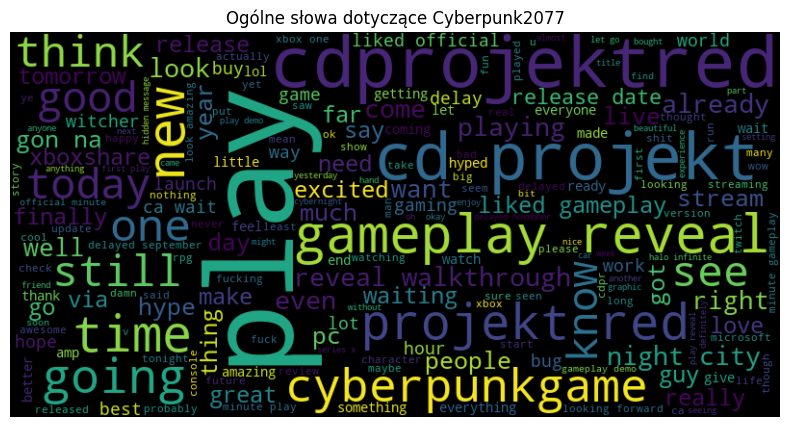

In [29]:
import csv
import re
import nltk
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def wordClouds(tweets, name):
    wordcloud_text = ' '.join(tweets)

    wordcloud = WordCloud(width=800, height=400).generate(wordcloud_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)
    plt.show()


all_tweets = tweets_first_trailer + tweets_first_gameplay + tweets_first_move + tweets_second_move+ tweets_third_move+ tweets_before_release + tweets_after_release

wordClouds(all_tweets,"Ogólne słowa dotyczące Cyberpunk2077")

Ogólne słowa pokazują nastawienie publiki ('hype','excited','liked','buy'), jak i zawierają ogólne informacje ('cdprojektred','play','gameplay reveal').

Następnie wszystkie tweety z danych okresów zostaną podzielone na pozytywne i negatywne.

### Słowa padające w kontekście każdej z 5 emocji związanych z Cyberpunkiem2077

In [ ]:
from text2emotion import get_emotion
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def process_tweets(all_tweets):
    happy_tweets = []
    sadness_tweets = []
    anger_tweets = []
    fear_tweets = []
    surprise_tweets = []

    for tweet in all_tweets:
        emotions = get_emotion(tweet)
        dominant_emotion = max(emotions, key=emotions.get)

        if dominant_emotion == 'Happy':
            happy_tweets.append(tweet)
        elif dominant_emotion == 'Sad':
            sadness_tweets.append(tweet)
        elif dominant_emotion == 'Angry':
            anger_tweets.append(tweet)
        elif dominant_emotion == 'Fear':
            fear_tweets.append(tweet)
        elif dominant_emotion == 'Surprise':
            surprise_tweets.append(tweet)
            
    

    wordClouds(happy_tweets,"Happy tweets")
    wordClouds(sadness_tweets,"Sad tweets")
    wordClouds(anger_tweets,"Angry tweets")
    wordClouds(fear_tweets,"Fear tweets")
    wordClouds(surprise_tweets,"Surprise tweets")


process_tweets(all_tweets)

TODO: komentarze

### Słowa padające w kazdym z okresów
Analiza jakie słowa padją w tweetach pozytywnych i negatywnych w każdym z siedmu okresów. Tweety są podzielone na te pozytywne i negatywne. Warunkiem, aby określić tweet jako **negatywny** jest wartość nastawienia **<= -0.05**, dla **pozytywnych** **>= 0.05**. Tweety z nastawieniem pomiędzy tymi wynikami traktujemy jako neutralne i je pomijamy.

In [ ]:
def analiza(tweets,topic):
    sia = SentimentIntensityAnalyzer()
    positive_tweets=[]
    negative_tweets=[]
    for tweet in tweets:
        sentiment = sia.polarity_scores(tweet)
        if sentiment['compound'] >= 0.05:
            positive_tweets.append(tweet)
        elif sentiment['compound'] <= -0.05:
            negative_tweets.append(tweet)

    wordClouds(positive_tweets,'Pozytywne określenia odnośnie ' + topic)
    wordClouds(negative_tweets,'Negatywne określenia odnośnie '+ topic)

In [ ]:
analiza(tweets_first_trailer,'pierwszego zwiastuna')

Komentarze odnoście pierwszego zwiastuna gry:
- W pierwszej chmurze słów dominują pozytywne określenia ('liked','good','great','best'), co wskazuje na znacznie przychylną ocenę opinii publicznej.
- W drugiej chmurze słów znajdą się głównie słowa, które można za uznać za neutralne ('new'.'year','conference'), jak i przekleństwa. Obecność tych ostatnich wcale nie musi znaczyć negatywnego nacechowania wypowiedzi. W tym przypadku widocznie algorytm sklasyfikował wypowiedzi z przekleństwami jako negatywne, głównie z powodu kolokwialnego języka.

In [ ]:
analiza(tweets_first_gameplay,'pierwszego zwiastuna rozgrywki')

Komentarze odnoście pierwszej prezentacji rozgrywki gry:
- W pierwszej chmurze słów również przeważają pozytywne określenia (liked, hype, excited, love), jak i wyrażenia dotyczące samego wydarzenia (gameplay reveal, walkthrough, official).
- W drugiej chmurze słów ponownie pojawia się problem z przekleństwami. Generalnie nie ma tu skrajnie negatywnych wrażeń, oprócz kilku (angry, rage, hard). Głównie dominują tu neutralne słowa. Wskazywać na to może bardzo pozytywny odbiór - tweety odebrane jako negatywne to tak naprawdę trochę mniej pozytywne.

In [ ]:
analiza(tweets_first_move,'pierwszego przesunięcia daty premiery')

Komentarze odnoście pierwszego przesunięcia daty premiery gry:
- W obu przypadkach dominują słowa dotyczące opóźnień i przeniesienia premiery.
- Pozytywne tweety zachowują optymizm, pojawiają się słowa aprobaty ('better','excited','ready','take time'), co wskazuje na poparcie fanów i zrozumienie powodów opóźnień. 
- W drugiej chmurze słów nie ma zbyt wiele określeń znacznie negatywnych, pojawia się 'bad', 'sad' -  bardziej w kontekście smutnej/złej nowiny. Te słowa nie wskazują na duże niezadowolenie.

In [ ]:
analiza(tweets_second_move,'drugiego przesunięcia daty premiery')

Komentarze odnoście drugiego przesunięcia daty premiery gry:
- W obu przypadkach dominują słowa dotyczące opóźnień i przeniesienia premiery.
- Pozytywne tweety pokazują optymizm ('hope','better','hopefully'), lecz tych określeń jest mnniej niż w poprzednim okresie i są słabsze.
- W drugiej chmurze przeważają informacje o opóźnieniu. Do tego pojawia się ('problem','damn','oh','disappointed') oraz czasem przekleństwa. Widać tu rosnącą frustrację opinii publicznej.

In [ ]:
analiza(tweets_third_move,'trzeciego przesunięcia daty premiery')

Komentarze odnoście trzeciego przesunięcia daty premiery gry:
- W obu przypadkach dominuje słowo "crunch" oznaczające zjawisko, które wynika z rychłej konieczności zwiększenia natężenia prac nad projektem, co wiąże się to praktycznie z mieszkaniem w biurze przez kilka dni przez pracowników. Oprócz tego dominują synonimy opóźnienia.
- Pozytywne tweety pokazują mają wciąż nadzieję ('hope','statue perfection','prefection cost'), lecz te słowa wyraźnie "toną" pod naporem słów o opóźnieniach
- Negatywne tweety wskazują na niezadowolenie sytuacją ('bad','really','report developer','despite promise','shit').

In [ ]:
analiza(tweets_before_release,'oczekiwań przed premierą')

Komentarze przed dniem premiery gry:
- W obu przypadkach wiele słów wskazuje na oczekiwanie i chęci zagrania w grę.
- Pozytywne tweety ('finally','great','beautiful','hope','good') pokazują duże oczekiwania pomimo obsunięć czasowych.
- W negatywnych tweetach ('sorry','hate','bad','problem','spoiler','sad') widać przewidywania, że gra nie spełni oczekiwań.

In [ ]:
analiza(tweets_after_release,'wrażeń po premierze')

Komentarze po dniu premiery gry:
- Pozytywne komentarze skupiają się na wielu pozytywach ('good','better','want','love','story','fun','super'). Fani doceniają różne aspekty gry. 
- W negatywnych tweetach można zauważyć skupienie się na gorszych stronach ('bad','bug','shit','release problem','crash'), takie jak błędy czy niespełnienie oczekiwań.


## Analiza czasowa według wybranych okresów
Poniższy wykres zaprezentuje, jak zmieniały się dane emocje na przestrzeni czasu od maja 2018 do grudnia 2020. Wartości są badane tylko w danych okresach. Emocje są podzielone na 5 emocji: Happy(szczęście), Angry(złość), Surprise(zaskoczenie), Sad(smutek), Fear(strach).

In [ ]:
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import text2emotion as te


def calculate_average_emotions(files):
    emotions = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
    dates = []
    all_emotions = []

    for file in files:
    
        averages = {emotion: 0 for emotion in emotions}
        data = pd.read_csv(file)
        file_length = len(data)
        dates.append(data['Date'].values[0])

        for content in data['Content']:
            result = te.get_emotion(content)


            for emotion in emotions:
                averages[emotion] += result[emotion]

        for emotion in emotions:
            averages[emotion] = averages[emotion] / file_length

        all_emotions.append(averages)

    plot_emotion_changes(dates,all_emotions)



def plot_emotion_changes(dates, emotions):
    plt.figure(figsize=(20, 6))
    x = [datetime.strptime(date, "%Y-%m-%d %H:%M:%S%z") for date in dates]
    y_happy = [emotion['Happy'] for emotion in emotions]
    y_angry = [emotion['Angry'] for emotion in emotions]
    y_surprise = [emotion['Surprise'] for emotion in emotions]
    y_sad = [emotion['Sad'] for emotion in emotions]
    y_fear = [emotion['Fear'] for emotion in emotions]

    fig, ax = plt.subplots()
    ax.yaxis.tick_left()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

    ax.plot(x, y_happy, label='Happy', color='g', marker='o')
    ax.plot(x, y_angry, label='Angry', color='r', marker='o')
    ax.plot(x, y_surprise, label='Surprise', color='c', marker='o')
    ax.plot(x, y_sad, label='Sad', color='b', marker='o')
    ax.plot(x, y_fear, label='Fear', color='m', marker='o')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Data')
    ax.set_ylabel('Poziom Emocji')
    plt.xticks(rotation=45)

    ax.grid()
    plt.title('Analiza Czasowa Emocji')
    plt.savefig('Analiza Czasowa Emocji.png')
    plt.show()


file_paths = ['data_ENGLISH/ENG_first_trailer.csv', 'data_ENGLISH/ENG_first_gameplay.csv', 'data_ENGLISH/ENG_first_move.csv',
              'data_ENGLISH/ENG_second_move.csv', 'data_ENGLISH/ENG_third_move.csv', 'data_ENGLISH/ENG_before_release.csv', 'data_ENGLISH/ENG_after_release.csv']
calculate_average_emotions(file_paths)

Na wykresie każdy punkt jest wartością danej emocji w podanym dniu.
- Pierwszy punkt - **prezentacja pierwszego zwiastuna**, wysoki poziom zaskoczenia, jak i strachu (w kontekście czy sprosta oczekiwaniom)
- Drugi punkt - **prezentacja rozgrywki**, poziom zaskoczenia rośnie jeszcze bardziej, smutek spada
- Trzeci punkt - **pierwsze opóźnienie**, duży poziom strachu, znacznie wzrósł smutek, strach i szczęście. Poziom zaskoczenia spadł, lecz wciąż jest wysoko.
- Czwarty punkt - **drugie opóźnienie**, większość emocji jest na podobnym poziomie co wcześniej, co wskazuje na to, że wywołał podobne odczucia
- Piąty punkt - **trzecie opóźnienie**, Widoczny wzrost strachu (o spełnienie oczekiwań i jakość produktu). Smutek i zaskoczenie również osiągają wyższe wyniki, minimalnie wzrasta złość.
- Szósty punkt - **emocje przed premierą**, Poziom strachu osiąga swoje maximum, zmniejsza się smutek, zaskoczenie i złość - co sugeruje ostudzenie emocji
- Siódmy punkt - **emocje po premierze**, Spadła wartość zaskoczenia, minimalnie wzrósł smutek. Wciąż panuje wysoki poziom strachu.

## Analiza czasowa w czasie premiery
Wykres pokazuje zmianę emocji każdego dnia od 1 listopada 2020 do 27 lutego 2021, czyli przed i po premierze.
Pod nim również codzienne zmiany kursu CD Projekt Red (developera gry) na giełdzie w tym samym przedziale czasowym. W czasie każdego dnia zostało pobrane 300 tweetów i na nich będą badane zmiany.

In [ ]:
def calculate_average_emotions(file):
    emotions = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
    tweets = 0
    tweets_per_day = 300
    data = pd.read_csv(file)
    all_emotions = []

    data['Date'] = pd.to_datetime(data['Date'])
    unikalne_daty = data['Date'].dt.date.unique()

    for date in unikalne_daty:
        subset = data[data['Date'].dt.date == date]
        content = subset['Content'].tolist()
        if tweets == 35705:
            break

        for i in range(0, len(content), tweets_per_day):
            batch = content[i:i + tweets_per_day]
            averages = {emotion: 0 for emotion in emotions}
            for content in batch:
                tweets += 1

                result = te.get_emotion(content)
                print(tweets)

                for emotion in emotions:
                    averages[emotion] += result[emotion]

            for emotion in emotions:
                averages[emotion] = averages[emotion] / tweets_per_day

            all_emotions.append(averages)
            print(all_emotions)

    data_string = []
    for data in unikalne_daty:
        data_string.append(data.strftime('%Y-%m-%d'))

    unikalne_daty = data_string
    plot_emotion_changes(unikalne_daty,all_emotions)



def plot_emotion_changes(dates, emotions):
    plt.figure(figsize=(20, 6))
    x = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    y_happy = [emotion['Happy'] for emotion in emotions]
    y_angry = [emotion['Angry'] for emotion in emotions]
    y_surprise = [emotion['Surprise'] for emotion in emotions]
    y_sad = [emotion['Sad'] for emotion in emotions]
    y_fear = [emotion['Fear'] for emotion in emotions]

    fig, ax = plt.subplots()
    ax.yaxis.tick_left()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

    ax.plot(x, y_happy, label='Happy', color='g')
    ax.plot(x, y_angry, label='Angry', color='r')
    ax.plot(x, y_surprise, label='Surprise', color='c')
    ax.plot(x, y_sad, label='Sad', color='b')
    ax.plot(x, y_fear, label='Fear', color='m')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Data')
    ax.set_ylabel('Poziom Emocji')
    plt.xticks(rotation=45)

    ax.grid()
    plt.title('Analiza Czasowa Emocji od listopada 2020 do lutego 2021')
    plt.savefig('Analiza Czasowa Emocji - daily.png')
    plt.show()


file= 'data_ENGLISH/ENG_daily_tweets.csv'
calculate_average_emotions(file)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data_MIXED/CDP-kursy.csv')

df['Data'] = pd.to_datetime(df['Data'])

plt.figure(figsize=(20, 6))
plt.plot(df['Data'], df['Zamknięcie'])
plt.xlabel('Data')
plt.ylabel('Zamknięcie')
plt.title('Wykres kursu spółki')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

komentarz do wykresów

# 4. Podsumowanie
coś o tym że zbadane emocje mniej więcej oddają wrażenia jakie wtedy były
to czy odzwierciedlają zmiany na giełdzie
to że trochę nie dokłdanie np. przekleństwa czy 
czy 0.05 to była dobra wartość
i czy może trochę można było odfiltrować

# 5. Bibliografia
- https://www.focus.pl/artykul/crunch-swiat-gamingu-dobrze-zna-to-zjawisko-i-raczej-go-nie-lubi
- https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
- https://realpython.com/python-nltk-sentiment-analysis/
- https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/
- https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
- https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
- https://www.datacamp.com/community/tutorials/wordcloud-python
- https://open.spotify.com/playlist/37i9dQZF1DX5KpP2LN299J?si=c7bc36e7bfd245a2
- https://amueller.github.io/word_cloud/https://pypi.org/project/wordcloud/
- https://pl.wiktionary.org/wiki/zwiastun
- https://www.money.pl/gielda/spolki-gpw/plopttc00011,archiwum.html